In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

# Preprocessing

In [2]:
data_base_dir="/kaggle/input/plastic-waste"

In [3]:
classes=[c.lower() for c in os.listdir(data_base_dir)]
print(classes)

['metal', 'paper', 'plastic']


In [4]:
data=[]
data_dir_for_class = ['Metal/Metal', 'Paper/Paper', 'Plastic/Plastic']

for c in classes:
    i=classes.index(c)
    path=os.path.join(data_base_dir, data_dir_for_class[i])
    for idx, img in enumerate(os.listdir(path)):
        im=cv2.imread(os.path.join(path,img))
        im=cv2.resize(im,(224,224))
        data.append([im,i])

In [5]:
data_bak = data

In [6]:
data=np.array(data)
np.random.shuffle(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [7]:
X=[]
Y=[]
for x,y in data:
    X.append(x)
    Y.append(y)

In [11]:
x=np.array(X)
y=np.array(Y)
print(x.shape,y.shape)

(1240, 224, 224, 3) (1240,)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=4, stratify=y)

In [13]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(868, 224, 224, 3) (868,)
(372, 224, 224, 3) (372,)


# Build DenseNet169 Model

In [15]:
model_denseNet169=tf.keras.applications.densenet.DenseNet169(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=3,
    classifier_activation='softmax'
)

In [ ]:
model_denseNet169.summary()

In [16]:
base_input3=model_denseNet169.layers[0].input
base_output3=model_denseNet169.layers[-2].output

final_output3 = layers.Dense(240)(base_output3) 
final_output3 = layers.Activation('relu')(final_output3) 
final_output3 = layers.Dense(120)(final_output3) 
final_output3 = layers.Activation('relu')(final_output3) 
final_output3 = layers.Dense(60)(final_output3)
final_output3 = layers.Activation('relu')(final_output3)
final_output3 = layers.Dense(3, activation='softmax')(final_output3) 

In [17]:
new_model_denseNet169 = tf.keras.Model(inputs = base_input3, outputs = final_output3)

In [18]:
new_model_denseNet169.compile(loss="sparse_categorical_crossentropy", optimizer = "SGD", metrics = ["accuracy"])

# Train DenseNet169 Model

In [19]:
checkpoint_filepath = '/kaggle/working/waste_segregation_model_denseNet169_wout_imagenet.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=8,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [20]:
result_D = new_model_denseNet169.fit(
    x_train, y_train, 
    epochs = 30,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
28/28 [==============================] - 85s 937ms/step - loss: 0.7354 - accuracy: 0.8134 - val_loss: 1.0867 - val_accuracy: 0.4005
Epoch 2/30
28/28 [==============================] - 12s 446ms/step - loss: 0.3616 - accuracy: 0.8963 - val_loss: 1.1070 - val_accuracy: 0.4005
Epoch 3/30
28/28 [==============================] - 14s 491ms/step - loss: 0.2607 - accuracy: 0.9251 - val_loss: 1.1975 - val_accuracy: 0.4005
Epoch 4/30
28/28 [==============================] - 13s 449ms/step - loss: 0.2266 - accuracy: 0.9274 - val_loss: 1.4592 - val_accuracy: 0.4005
Epoch 5/30
28/28 [==============================] - 14s 495ms/step - loss: 0.1643 - accuracy: 0.9493 - val_loss: 1.6991 - val_accuracy: 0.4005
Epoch 6/30
28/28 [==============================] - 14s 501ms/step - loss: 0.1912 - accuracy: 0.9274 - val_loss: 1.3981 - val_accuracy: 0.4005
Epoch 7/30
28/28 [==============================] - 13s 452ms/step - loss: 0.1402 - accuracy: 0.9597 - val_loss: 2.3149 - val_accuracy: 0.4005

In [49]:
new_model = tf.keras.models.load_model(checkpoint_filepath)

In [51]:
import cv2
from random import randint

In [52]:
test_imgs = list()
prev_idx = None
for i in range(5):
    cur_idx = randint(0, 630)
    while cur_idx == prev_idx:
        cur_idx = randint(0, 630)
        
    img = np.reshape(x_test[cur_idx], [1, 224, 224, 3])
    img_class = y_test[cur_idx]
    
    test_imgs.append((img, img_class))
    
    prev_idx = cur_idx

In [73]:
for i in range(5):
    res = new_model.predict(test_imgs[i][0])
    max_val = np.max(res)
    res = res.tolist()
    print(
        f"predicted class: {classes[res[0].index(max_val)]}, actual class: {classes[test_imgs[i][1]]}"
    )

1/1 [==============================] - 0s 44ms/step

predicted class: cardboard, actual class: cardboard

1/1 [==============================] - 0s 41ms/step

predicted class: cardboard, actual class: cardboard

1/1 [==============================] - 0s 62ms/step

predicted class: cardboard, actual class: cardboard

1/1 [==============================] - 0s 77ms/step

predicted class: cardboard, actual class: cardboard

1/1 [==============================] - 0s 73ms/step

predicted class: glass, actual class: glass


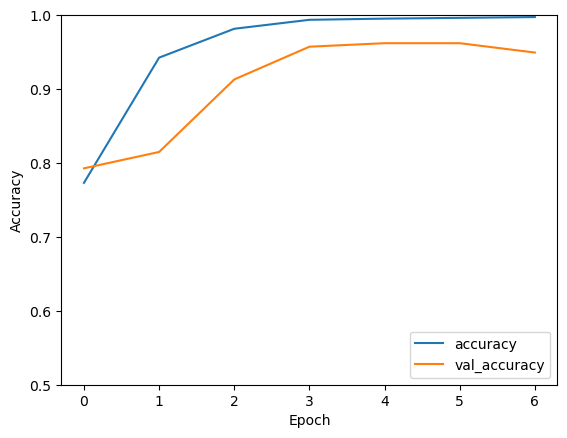

In [42]:
plt.plot(result_D.history['accuracy'], label='accuracy')
plt.plot(result_D.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')